# Lifecycle investing: a statistical approach

This work is reproducing the approach to lifecycle investing using different statistical techniques. In traditional lifecycle investing numerical dynamic programming (NDP) is used to optimize for the consumption of the agent and derive the optimal asset allocation trough time. In our approach we use instead neural networks to derive it.

## Lifecycle Investing

Description of Lifecycle Investing, definition of parameters used, current approach to the solution

The utility function we are optimizing is:

$$V_t(x_t) = \left\{ \left( 1 - \delta \right)C_t^{1-1/\psi} + \delta E_t\left[ p_tV_{t+1}(x_{t+1})^{1-\gamma} \right]^{\frac{1-1/\psi}{1 - \gamma}} \right\}^{\frac{1}{1 - 1/\psi}}$$

When the bequest motive is equal to 0.

The equation is subject to a constrain:

$$x_{t+1} = income_{t+1} + R^p_{t+1}(x_t - C_t)$$

and the return $R^p$ is defined as the return of the portfolio mix between the risky and non risky assets:

$$ R^p_{t+1} = \alpha R_{t+1} + (1 - \alpha)R_f$$

In [1]:
# load libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import investor
import lifecycle

In [2]:
consumption_policy, equity_policy, utility_result = lifecycle.optimize_lifecycle()

C:\Users\AS\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\Users\AS\rep\ucl_final_project\lifecycle.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  value = ((((1 - investor.DELTA) * x[0] ** (1 - 1 / investor.PSI)) +


Training finished.


<AxesSubplot:>

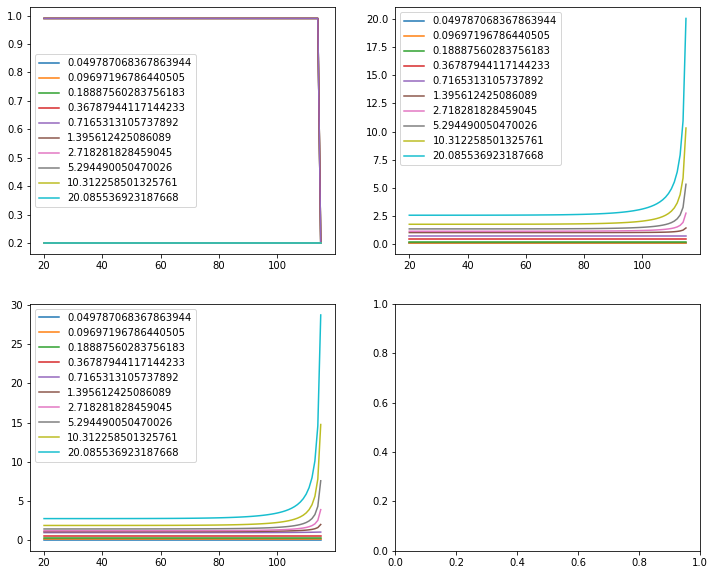

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (12, 10))
equity_policy.plot(ax = axes[0, 0])
utility_result.plot(ax = axes[1, 0])
consumption_policy.plot(ax = axes[0, 1])

In [4]:
def run_lifecycle(iterations = 100):
    income = [0] * investor.START_AGE
    risk_asset_return = [0] * investor.START_AGE
    permanent_income = []
    enne_list = []
    P_t = np.random.normal(scale = income_volatility)
        
    # I use this loop to generate the income and the returns
    for current_age in investor.AGE_LEVELS:
        risk_asset_return.append(np.random.normal(loc = risk_asset_average_return,
                                                scale = risk_asset_volatility))
        if (current_age < retirement_age):
            income.append(math.exp(initial_income + P_t + np.random.normal(scale = income_volatility)))
        else:
            income.append(0)                                     
        enne_t = np.random.normal(scale = income_volatility)
        permanent_income.append(P_t)
        P_t = P_t + enne_t
        enne_list.append(enne_t)
        # I need to introduce retirement income here too

        income_distribution_list.append(income)
        return_distribution_list.append(risk_asset_return)

In [5]:
pd.DataFrame(np.mean(np.array(return_distribution_list), axis=0)[start_age:], 
    index = range(start_age, end_age),
    columns=["returns"]).plot(ax = axes[0, 1])
pd.DataFrame(np.mean(np.array(income_distribution_list), axis=0)[start_age:], 
    index = range(start_age, end_age),
    columns=["income"]).plot(ax = axes[1, 1])

NameError: name 'return_distribution_list' is not defined